# Create synthetic SLE dataset

This notebook is used to create a synthetic dataset of "scanned" images showing single systems of linear equations. These images are created by creating a random matrix and column vector as the major parts of such a SLE. Then images of a kaggle dataset provided by Xai Nano (https://www.kaggle.com/xainano/handwrittenmathsymbols) are concatenated accordingly.
In a last step the images and a csv with information annotating the images are stored locally.

In [8]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
import os
from PIL import Image
import math
import time
import cv2 as cv
import csv
import pandas as pd

In [9]:
#set accordingly
KAGGLE_SYMBOL_DIRECTORY = 'C:\\Users\\bened\\ML_datasets\\kaggle_handwritten_symbols'

## Create random SLEs

As a first approach we create only solvable SLEs. 

$$
A \times x = b
$$

Integer values are assigned randomly to the three variables x, y and z. Next we have to randomly fill a 3x3 matrix with values so that all the row vectors are linearily indpendent to ensure that the system has a unique solution. Then we have to compute the vector on the right side auf the equation by multiplying the matrix with the solution vector.
SLE exercises assigned to students in school normally provide factos in the range of -20 to 20.



In [10]:
def create_sle_parts(size):
    #values for x, y, z (unique solution of the SLE)
    min_int = -20
    max_int = 20
    
    
    x = np.random.randint(min_int, max_int, size = size[0])
    print(f"random solution picked: {x}")

    A = np.random.randint(min_int, max_int, size = size)
    print("matrix A:")
    print(A)
    
    #check if linear dependent, if yes create a new one
    eigenvalues, eigenvectors_norm = np.linalg.eig(A)

    while (np.product(eigenvalues) == 0):
        A = np.random.randint(min_int, max_int, size = size)
        eigenvalues, eigenvectors_norm = np.linalg.eig(A)
        print("linear dependent, calculate new A")

    b = np.matmul(A, x)
    print(f"right side b: {b}")

    #check if SLE has unqiue solution and if calulated solution is same as randomly assigned one
    solution = np.matrix.round(np.matmul(np.linalg.inv(A) , b), decimals = 0).astype(int)
    print(f"computed solution as check: {solution}")

    assert (x == solution).all(), "solution created and solution computed are not equal!"
    
    return (A, x, b)

A, _, b = create_sle_parts((3,3))

random solution picked: [ 16 -18  10]
matrix A:
[[ 19  -1   8]
 [ -1   2  -3]
 [-12  -3  -4]]
right side b: [ 402  -82 -178]
computed solution as check: [ 16 -18  10]


## Split equations to chars and fetch images

The digital representation of the SLE (matrix A, x and b) are split to single chars and image files showing these chars are gathered accordingly.

In [11]:
def get_symbol_image(directory, symbol):
    """get the file path for an image containing a single symbol
    params:
        directory: parent directory with children: '1', '-' containing the images
        symbol: char
    returns:
        filepath
    """
    
    folder = os.path.join(directory, symbol)
    filename =  os.listdir(folder)[np.random.randint(len(os.listdir(folder)))]
    filepath = os.path.join(folder, filename)
    
    return filepath


def parse_chars(A, b):
    """parse single chars from matrix A and vectors b and x
    params:
        A: matrix, numpy
        b: column vector
    """
    
    
    symbol_dir = KAGGLE_SYMBOL_DIRECTORY
    variables_chars = ['x', 'y', 'z']
    #folder X renamed to x -> add to docs

    images_paths = []
    chars = []
    for row in range(A.shape[1]):

        row_images = []
        row_chars = []

        for col in range(A.shape[0]):
            if str(A[row, col])[0] != '-':
                imagepath = get_symbol_image(symbol_dir, '+')
                row_images.append(imagepath)
                row_chars.append('+')
            for char in str(A[row, col]):
                imagepath = get_symbol_image(symbol_dir, char)
                row_images.append(imagepath)
                row_chars.append(char)

            imagepath = get_symbol_image(symbol_dir, variables_chars[col])
            row_images.append(imagepath)
            row_chars.append(variables_chars[col])


        imagepath = get_symbol_image(symbol_dir, '=')
        row_images.append(imagepath)
        row_chars.append('=')

        for char_b in str(b[row]):
            imagepath = get_symbol_image(symbol_dir, char_b)
            row_images.append(imagepath)
            row_chars.append(char_b)

        images_paths.append(row_images)
        chars.append(row_chars)
        
    return images_paths, chars

image_paths, chars = parse_chars(A, b)

## Concat to one image per line

Now that each char in the equations is mapped to its responding images file these files can be concatenated to get one single image per line.

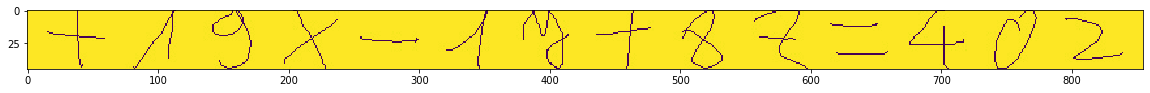

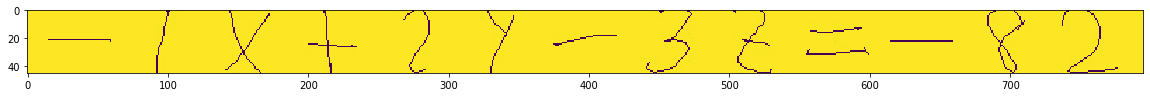

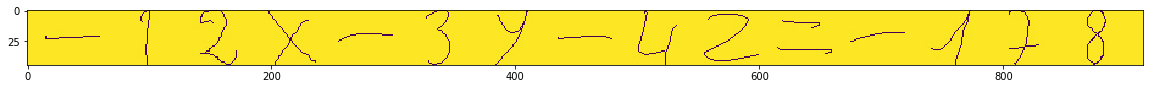

In [12]:
def calc_max_width(line_images):
    """calculate with of the widest image"""
    widths = [line.shape[1] for line in line_images]
    
    return max(widths)
    
def concat_2_line_images(paths, plot = False):
    """concatenates the images to one image per line using padding"""
    height = 45
    width = 45
    padding_x = math.ceil(width / 3)
    empty_value = 255
    line_images = []
    
    for line in paths:
        line_image = np.full([height, padding_x], empty_value)
        
        for imagepath in line:
            with Image.open(imagepath) as image:
                array = np.array(image)
                line_image = np.concatenate((line_image, array), axis = 1)
                line_image = np.concatenate((line_image, np.full([height, padding_x], empty_value)), axis = 1)
        line_images.append(line_image)
        
        if plot:
            fig = plt.figure(figsize = (20,30))
            plt.imshow(line_image, figure = fig)
            plt.show()
    
    return line_images

line_images = concat_2_line_images(image_paths, plot = True)

outer padding added to line: 30
(75, 915)
outer padding added to line: 60
(75, 915)
outer padding added to line: 0
(75, 915)


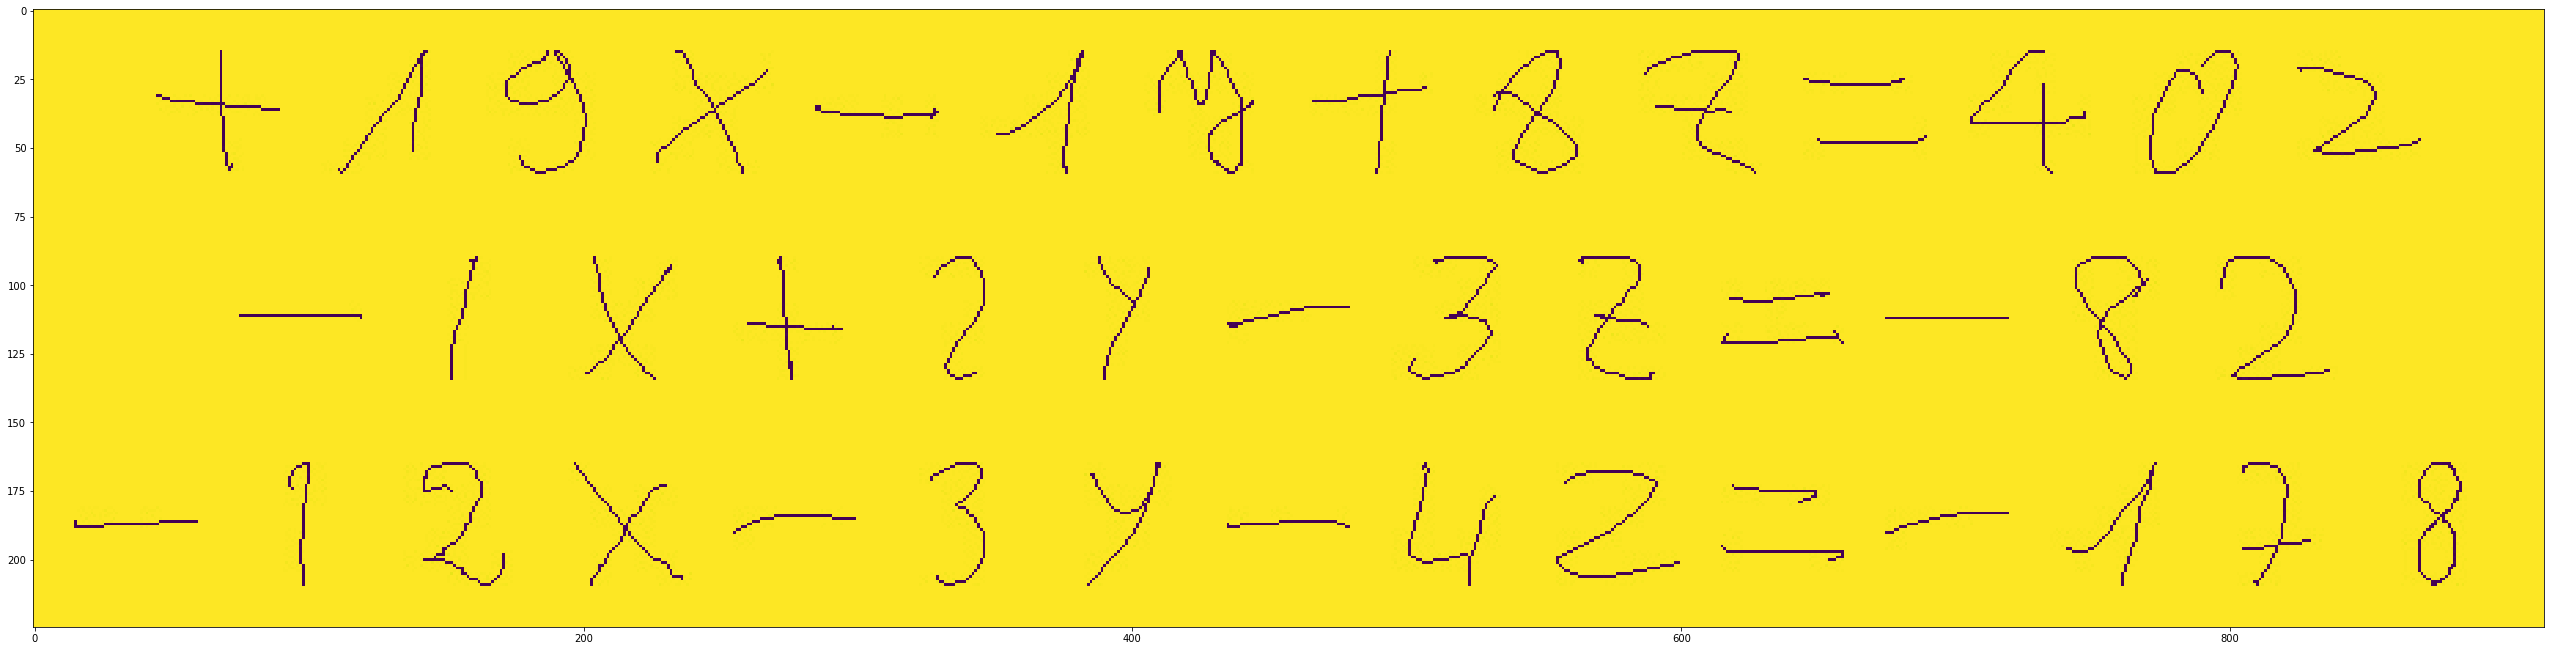

In [13]:
def concat_2_single_image(line_images, plot = False):
    """concatenates the line images to one single image showing the whole SLE"""
    
    max_width = calc_max_width(line_images)
    
    padded_images = []
    empty_value = 255
    
    for image in line_images:
        
        #now add some padding to each line and concatenate to a single image
        padding_y = int(image.shape[0] / 3)
        image = np.concatenate((np.full([padding_y, image.shape[1]], empty_value ), image), axis = 0)
        image = np.concatenate((image, np.full([padding_y, image.shape[1]], empty_value )), axis = 0)

        #pad left and right of image to allow vertical stacking
        outer_padding_left = math.ceil((max_width - image.shape[1]) / 2)
        outer_padding_right = math.floor((max_width - image.shape[1]) / 2)
        print(f"outer padding added to line: {outer_padding_left}")

        image = np.concatenate((np.full([image.shape[0], outer_padding_left], empty_value ), image), axis = 1)
        image = np.concatenate(( image, np.full([image.shape[0], outer_padding_right], empty_value )), axis = 1)
        print(image.shape)
        padded_images.append(image)

    final_image = np.concatenate(padded_images, axis = 0)

    if plot:
        fig = plt.figure(figsize = (45,45))
        plt.imshow(final_image, figure = fig)
        plt.show()
    
    return final_image

final_image = concat_2_single_image(line_images, plot = True)

## Postprocess the image

Let's inspect a scanned image to see how the real world looks like.

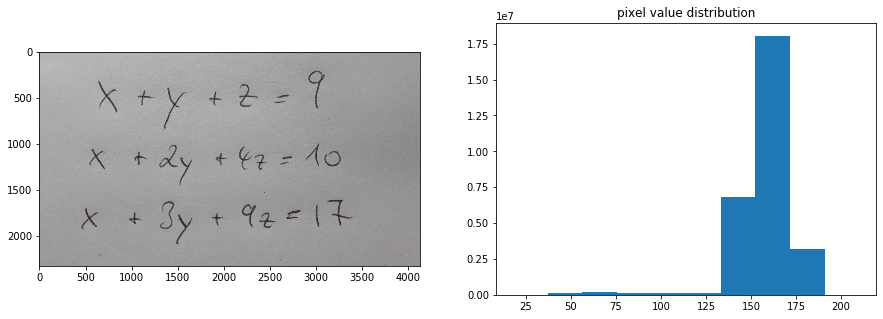

image shape: height 2322, width 4128, channels 3


In [14]:
src = cv.imread('./data/manually_scanned_sles/test_handwritten_white_separated_1.jpg')
image = src.copy()


fig, axes = plt.subplots(1, 2, figsize = (15, 5))
axes[0].imshow(image)
axes[1].hist(image.flatten())
axes[1].set_title("pixel value distribution")
plt.show()
print(f"image shape: height {image.shape[0]}, width {image.shape[1]}, channels {image.shape[2]}")

Strokes seem a bit thin. So dilate the image.

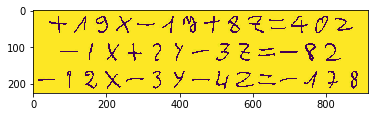

In [15]:
def dilate(image, iterations = 1, plot = False):
    """dilate the image"""
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
    image = ~image
    image_dilated = cv.dilate(np.float32(image), kernel, iterations = iterations)
    image_dilated = ~np.int32(image_dilated)
    
    if plot:
        plt.imshow(image_dilated)
        plt.show
        
    return image_dilated
image_dilated  = dilate(final_image, 3, True)

And add some noise (random fragments) to it. Normal scanned images contain dark points resulting from small objects either on the sheet of paper itself or dust on the camera lens or sensor.

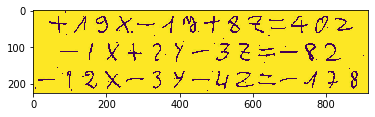

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

In [16]:
def add_fragments(image, n, max_size , plot = False):
    """
    params:
    image : original image array
    n: number of fragments to be added
    max_size: max pixel size of image as fractional of largest image dimension in promille
    plot: plot result
    """
 
    noisy = image.copy()
    fragment_max_size = math.ceil(max_size / 1000.0 * max(noisy.shape))
    fragments = []
    for i in range(n):

        x_random = np.random.randint(noisy.shape[0])
        y_random = np.random.randint(noisy.shape[1])
        fragment_shape = (np.random.randint(fragment_max_size), np.random.randint(fragment_max_size))

        noisy[max(x_random  - fragment_shape[0], 0) : x_random, max(y_random - fragment_shape[1], 0) : y_random] = np.min(image)

    if plot:
        plt.imshow(noisy)
        plt.show()
        
    return noisy
                  
add_fragments(image_dilated, 100, 5,  plot = True)
    

## Annotate and store images

Images are stored locally. Additionally a csv with some information annotating these images is created. With the help of the csv it is able to evaluate follow-up steps like calculating an accuracy score for the image parsing (number of symbols parsed vs. number of symbols in the image).

In [17]:
def annotate_image(directory, csv_filename, img_filename, symbols, A, b, solution, dila_steps, n_fragments, fragment_size):
    """creates a csv file annotating the created images e.g. matrix A, dilation steps used.."""
    
    csv_path = os.path.join(directory, csv_filename)
    filename = img_filename
    n_lines = A.shape[0]
    n_symbols = [len(row) for row in symbols]
    A = str(A).replace('\r', '').replace('\n', ',')
    symbols = str(symbols).replace("'", '')

    with open (csv_path, 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter = ";")
        writer.writerow(
            [
            filename,
            n_lines,
            n_symbols,
            symbols,
            A,
            b,
            solution,
            dila_steps,
            n_fragments,
            fragment_size
            ]
        )

In [18]:
def save_image(image_array, directory, symbols, A, b, solution, dila_steps, n_fragments, fragment_size):
    """saves an image locally and creates a csv file to annotate data"""
    
    os.makedirs(directory, exist_ok = True)
    image = Image.fromarray(image_array)
    image = image.convert( 'RGB')
    random = np.random.randint(1000)
    img_filename = 'sle_synthetic_' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()) + str(random) + '.jpg'
    
    image.save(os.path.join(directory, img_filename ))
    csv_filename = 'sle_image_annotations.csv'
    annotate_image(directory, csv_filename, img_filename, symbols, A, b, solution, dila_steps, n_fragments, fragment_size)

n_images = 30

for i in range(n_images):
    try:
        size = (3, 3)
        A, x, b = create_sle_parts(size)
        image_paths, symbols = parse_chars(A, b)
        line_images = concat_2_line_images(image_paths)
        final_image = concat_2_single_image(line_images)
        dila_steps = 3
        dilated_image = dilate(final_image, dila_steps)
        n_fragments = 100
        fragment_size = 5
        noisy_image = add_fragments(dilated_image, n_fragments, fragment_size )

        directory = './data/synthetic_scanned_sles'
        save_image(noisy_image, directory, symbols, A, b, x, dila_steps, n_fragments, fragment_size )
    except:
        print("image could not be created, continue with next image")

random solution picked: [16 15  5]
matrix A:
[[ -2 -10   2]
 [ -1  -8  11]
 [  1  15 -17]]
right side b: [-172  -81  156]
computed solution as check: [16 15  5]
outer padding added to line: 0
(75, 915)
outer padding added to line: 30
(75, 915)
outer padding added to line: 0
(75, 915)
random solution picked: [  1  14 -20]
matrix A:
[[ -4  16  -8]
 [ 15   3  16]
 [ 11 -11 -14]]
right side b: [ 380 -263  137]
computed solution as check: [  1  14 -20]
outer padding added to line: 60
(75, 975)
outer padding added to line: 0
(75, 975)
outer padding added to line: 0
(75, 975)
random solution picked: [ 19 -16  16]
matrix A:
[[ -8  10 -14]
 [ -9  -7 -18]
 [  0 -20 -11]]
right side b: [-536 -347  144]
computed solution as check: [ 19 -16  16]
outer padding added to line: 0
(75, 975)
outer padding added to line: 30
(75, 975)
outer padding added to line: 30
(75, 975)
random solution picked: [ -3  15 -11]
matrix A:
[[-18   7  19]
 [ -5  17  13]
 [-18   5   5]]
right side b: [-50 127  74]
computed s

outer padding added to line: 60
(75, 975)
outer padding added to line: 30
(75, 975)
outer padding added to line: 0
(75, 975)
random solution picked: [  6 -12  19]
matrix A:
[[-13  -2  15]
 [  9  -8 -12]
 [ 11   4 -17]]
right side b: [ 231  -78 -305]
computed solution as check: [  6 -12  19]
outer padding added to line: 30
(75, 975)
outer padding added to line: 60
(75, 975)
outer padding added to line: 0
(75, 975)


In [19]:
#check annotation
def parse_annotations(csv_file):
    df = pd.read_csv(csv_file, delimiter = ";", header = None, names =  ['file', 'n_rows', 'n_symbols', 'symbols', 'A', 'b', 'x', 'dilation', 'n_fragments', 'fragment_size'], index_col = 'file')
    return df

directory = './data/synthetic_scanned_sles'
csv_filename = 'sle_image_annotations.csv'
parse_annotations(os.path.join(directory, csv_filename))

,n_rows,n_symbols,symbols,A,b,x,dilation,n_fragments,fragment_size
file,,,,,,,,,
sle_synthetic_2020-10-23-15-01-06539.jpg,3,"[15, 14, 15]","[[-, 2, x, -, 1, 0, y, +, 2, z, =, -, 1, 7, 2]...","[[ -2 -10 2], [ -1 -8 11], [ 1 15 -17]]",[-172 -81 156],[16 15 5],3,100,5
sle_synthetic_2020-10-23-15-01-07601.jpg,3,"[14, 16, 16]","[[-, 4, x, +, 1, 6, y, -, 8, z, =, 3, 8, 0], [...","[[ -4 16 -8], [ 15 3 16], [ 11 -11 -14]]",[ 380 -263 137],[ 1 14 -20],3,100,5
sle_synthetic_2020-10-23-15-01-09654.jpg,3,"[16, 15, 15]","[[-, 8, x, +, 1, 0, y, -, 1, 4, z, =, -, 5, 3,...","[[ -8 10 -14], [ -9 -7 -18], [ 0 -20 -11]]",[-536 -347 144],[ 19 -16 16],3,100,5
sle_synthetic_2020-10-23-15-01-1078.jpg,3,"[15, 15, 13]","[[-, 1, 8, x, +, 7, y, +, 1, 9, z, =, -, 5, 0]...","[[-18 7 19], [ -5 17 13], [-18 5 5]]",[-50 127 74],[ -3 15 -11],3,100,5
sle_synthetic_2020-10-23-15-01-1218.jpg,3,"[13, 14, 15]","[[+, 0, x, -, 9, y, +, 8, z, =, -, 6, 9], [+, ...","[[ 0 -9 8], [ 0 -12 4], [-18 9 9]]",[ -69 -72 -234],[14 5 -3],3,100,5
sle_synthetic_2020-10-23-15-01-142.jpg,3,"[15, 15, 15]","[[-, 1, 1, x, -, 1, 3, y, -, 9, z, =, 3, 7, 8]...","[[-11 -13 -9], [ 0 -17 12], [ 8 -16 13]]",[378 378 222],[-18 -18 6],3,100,5
sle_synthetic_2020-10-23-15-01-15712.jpg,3,"[12, 15, 15]","[[-, 1, x, +, 7, y, +, 1, z, =, 7, 7], [-, 1, ...","[[ -1 7 1], [ -1 11 -15], [ 8 8 10]]",[ 77 245 -120],[-15 10 -8],3,100,5
sle_synthetic_2020-10-23-15-01-17311.jpg,3,"[14, 13, 15]","[[-, 1, 1, x, -, 2, 0, y, +, 2, z, =, 5, 8], [...","[[-11 -20 2], [ -8 -1 9], [ 10 17 -7]]",[ 58 -42 -68],[12 -9 5],3,100,5
sle_synthetic_2020-10-23-15-01-18270.jpg,3,"[14, 16, 14]","[[+, 7, x, +, 2, y, +, 6, z, =, -, 1, 8, 3], [...","[[ 7 2 6], [-19 -12 14], [ 0 -13 8]]",[-183 349 175],[-13 -19 -9],3,100,5
